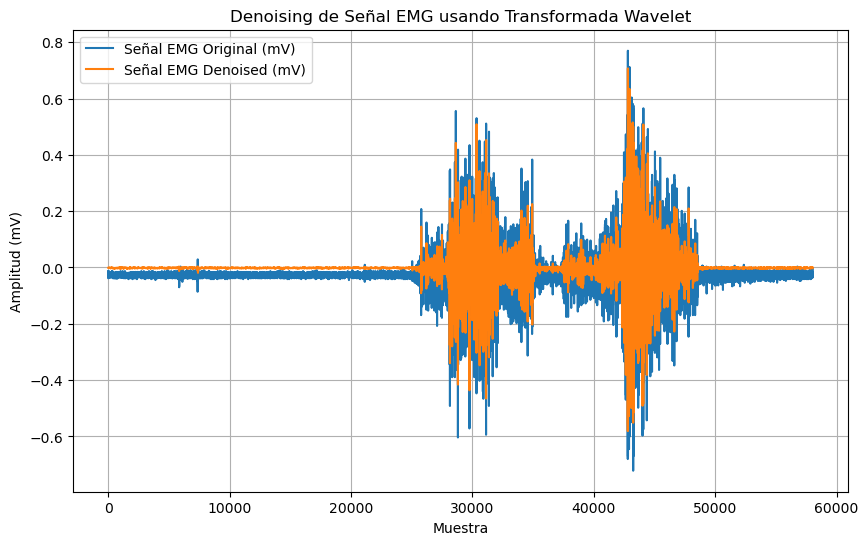

In [7]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Nombre del archivo de texto
archivo = "cesa 2-04-12_10-12-11.txt"

# Leer los datos del archivo y omitir las primeras 7 líneas
datos = np.loadtxt(archivo, skiprows=7)

# Extraer la columna de interés (columna 6)
senal = datos[:, 5]

# Preprocesamiento de la señal (ajustar según sea necesario)
# Suponiendo que se convierte a mV y se ajusta el rango dinámico
a = 2**10
senalV = (((senal/a)-1/2)*3.3)/1009  # Conversión a mV
senalmV = senalV * 1000  # Amplificación por 1000 para mayor claridad

# Definir parámetros de la transformada wavelet
wavelet = 'sym5'  # Wavelet Symlet con 5 momentos de desaparición
level = 4  # Nivel de descomposición
mode = 'symmetric'  # Modo de extensión de señal

# Realizar la descomposición wavelet
coefficients = pywt.wavedec(senalmV, wavelet, level=level, mode=mode)

# Método de umbralización y valor de umbral
threshold_method = 'soft'  # Método de umbralización soft
threshold_value = 0.1  # Ajustar el valor del umbral según su señal y nivel de ruido

# Aplicar umbralización a los coeficientes de la wavelet
coefficients_thresh = [pywt.threshold(c, threshold_value, mode=threshold_method) for c in coefficients]

# Reconstruir la señal denoised
emg_denoised = pywt.waverec(coefficients_thresh, wavelet, mode=mode)

# Graficar la señal EMG original y denoised
plt.figure(figsize=(10, 6))
plt.plot(senalmV, label='Señal EMG Original (mV)')
plt.plot(emg_denoised, label='Señal EMG Denoised (mV)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud (mV)')
plt.title('Denoising de Señal EMG usando Transformada Wavelet')
plt.legend()
plt.grid(True)
plt.show()


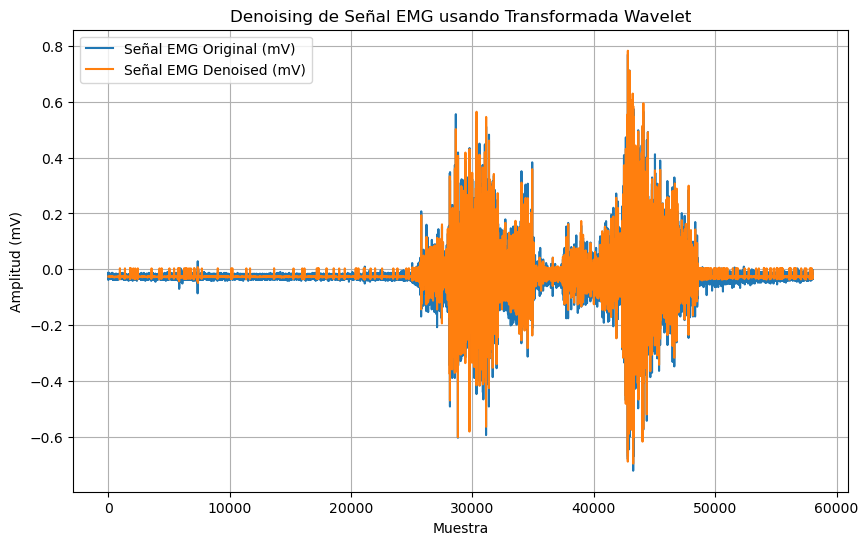

In [8]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Nombre del archivo de texto
archivo = "cesa 2-04-12_10-12-11.txt"
datos = np.loadtxt(archivo, skiprows=7)
senal = datos[:, 5]

# Preprocessing: assuming uniform sampling, converting signal to millivolts
num_muestra = np.arange(len(senal))
a = 2 ** 10
senalV = (((senal/a)-1/2)*3.3)/1009
senalmV = senalV * 1000

# Denoising parameters
wavelet = 'sym5'  # Wavelet type
level = 4          # Decomposition level
mode = 'symmetric' # Extension mode
threshold_method = 'hard'  # Thresholding method
threshold_value = 0.1      # Threshold value (adjust based on noise level and signal characteristics)

# Wavelet decomposition
coefficients = pywt.wavedec(senalmV, wavelet, level=level, mode=mode)

# Thresholding
coefficients_thresh = [pywt.threshold(c, threshold_value, mode=threshold_method) for c in coefficients]

# Reconstruction
emg_denoised = pywt.waverec(coefficients_thresh, wavelet, mode=mode)
# Graficar la señal EMG original y denoised
plt.figure(figsize=(10, 6))
plt.plot(senalmV, label='Señal EMG Original (mV)')
plt.plot(emg_denoised, label='Señal EMG Denoised (mV)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud (mV)')
plt.title('Denoising de Señal EMG usando Transformada Wavelet')
plt.legend()
plt.grid(True)
plt.show()

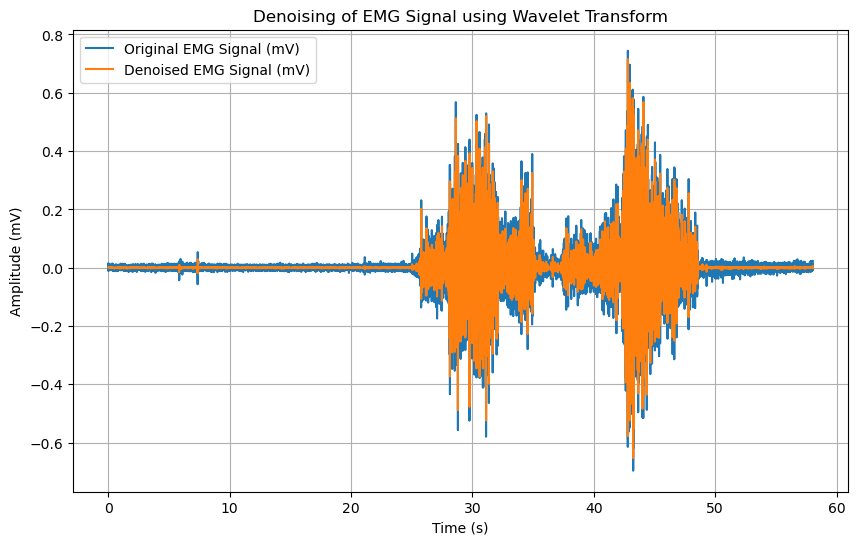

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt

# Load EMG signal data
archivo = "cesa 2-04-12_10-12-11.txt"
datos = np.loadtxt(archivo, skiprows=7)
senal = datos[:, 5]

# Create a time vector (assuming uniform sampling)
tiempo = np.arange(len(senal))

# Apply notch filter to remove power line interference (60 Hz for North America)
fs = 1000  # Sampling frequency assumed to be 1000 Hz
f0 = 60    # Power line frequency (North America)
Q = 30     # Quality factor
w0 = f0 / (fs / 2)  # Normalized frequency
b, a = signal.iirnotch(w0, Q)
senal_filtered = signal.filtfilt(b, a, senal)

# Preprocessing: assuming uniform sampling, converting signal to millivolts
num_muestra = np.arange(len(senal_filtered))
a = 2 ** 10
senalV = (((senal_filtered/a)-1/2)*3.3)/1009
senalmV = senalV * 1000

# Denoising parameters based on the PDF
wavelet = 'sym5'       # Wavelet type
level = 4              # Decomposition level
threshold_method = 'soft'  # Thresholding method
mode = 'symmetric'     # Extension mode

# Wavelet decomposition
coefficients = pywt.wavedec(senalmV, wavelet, level=level, mode=mode)

# Estimate the noise standard deviation for each detail coefficient level and apply soft thresholding
coefficients_thresh = [coefficients[0]]  # Keep approximation coefficients unchanged
for i in range(1, len(coefficients)):
    sigma = np.median(np.abs(coefficients[i])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(coefficients[i])))
    coefficients_thresh.append(pywt.threshold(coefficients[i], threshold, mode=threshold_method))

# Reconstruction
emg_denoised = pywt.waverec(coefficients_thresh, wavelet, mode=mode)

# Convert sample indices to time in seconds
tiempo_seconds = tiempo / 1000.0

# Center the denoised signal around 0 amplitude
emg_denoised_centered = emg_denoised - np.mean(emg_denoised)
# Center the original signal around 0 amplitude
senalV_centered = senalmV - np.mean(senalmV)

# Plot original and centered denoised signals in seconds
plt.figure(figsize=(10, 6))
plt.plot(tiempo_seconds, senalV_centered, label='Original EMG Signal (mV)')
plt.plot(tiempo_seconds, emg_denoised_centered, label='Denoised EMG Signal (mV)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Denoising of EMG Signal using Wavelet Transform')
plt.legend()
plt.grid(True)
plt.show()




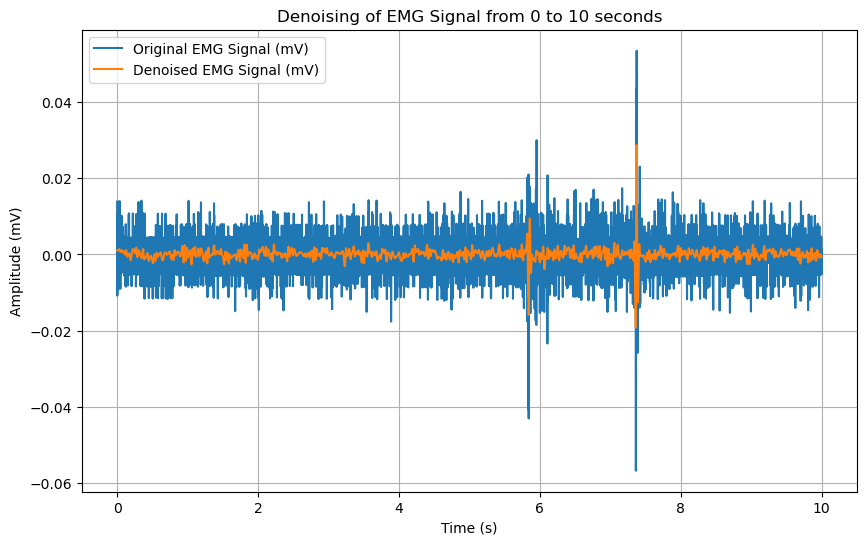

In [23]:
# Define the time range for the first 10 seconds
start_time = 0
end_time = 10

# Find the corresponding sample indices for the time range
start_index = int(start_time * fs)  # Convert start time to samples
end_index = int(end_time * fs)      # Convert end time to samples

# Slice the original and denoised signals for the first 10 seconds
senalmV_0_10 = senalV_centered[start_index:end_index]
emg_denoised_0_10 =emg_denoised_centered[start_index:end_index]
tiempo_seconds_0_10 = tiempo_seconds[start_index:end_index]

# Plot the original and denoised signals for the first 10 seconds
plt.figure(figsize=(10, 6))
plt.plot(tiempo_seconds_0_10, senalmV_0_10, label='Original EMG Signal (mV)')
plt.plot(tiempo_seconds_0_10, emg_denoised_0_10, label='Denoised EMG Signal (mV)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Denoising of EMG Signal from 0 to 10 seconds')
plt.legend()
plt.grid(True)
plt.show()

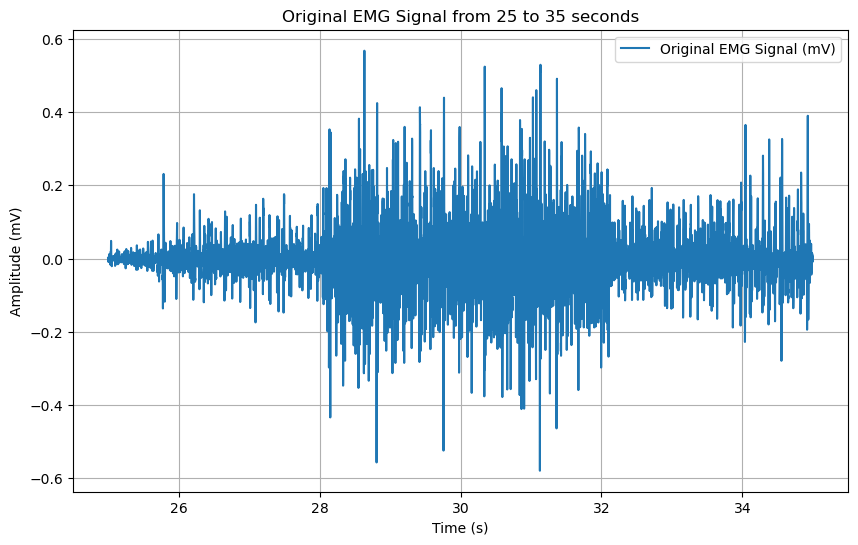

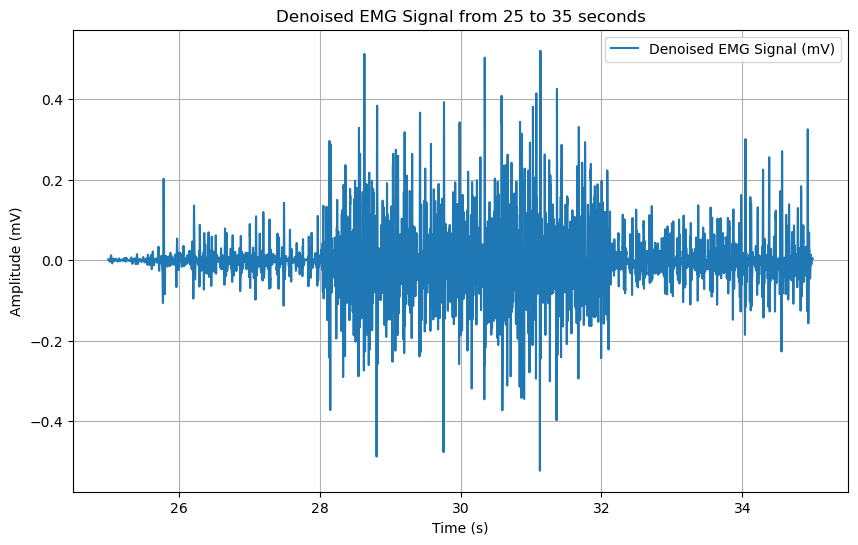

In [24]:
# Define the time range for the first 10 seconds
start_time = 25
end_time = 35

# Find the corresponding sample indices for the time range
start_index = int(start_time * fs)  # Convert start time to samples
end_index = int(end_time * fs)      # Convert end time to samples

# Slice the original and denoised signals for the first 10 seconds
senalmV_0_10 = senalV_centered[start_index:end_index]
emg_denoised_0_10 =emg_denoised_centered[start_index:end_index]
tiempo_seconds_0_10 = tiempo_seconds[start_index:end_index]

# Plot the original signal for the first 10 seconds
plt.figure(figsize=(10, 6))
plt.plot(tiempo_seconds_0_10, senalmV_0_10, label='Original EMG Signal (mV)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Original EMG Signal from 25 to 35 seconds')
plt.legend()
plt.grid(True)
plt.show()

# Plot the denoised signal for the first 10 seconds
plt.figure(figsize=(10, 6))
plt.plot(tiempo_seconds_0_10, emg_denoised_0_10, label='Denoised EMG Signal (mV)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Denoised EMG Signal from 25 to 35 seconds')
plt.legend()
plt.grid(True)
plt.show()

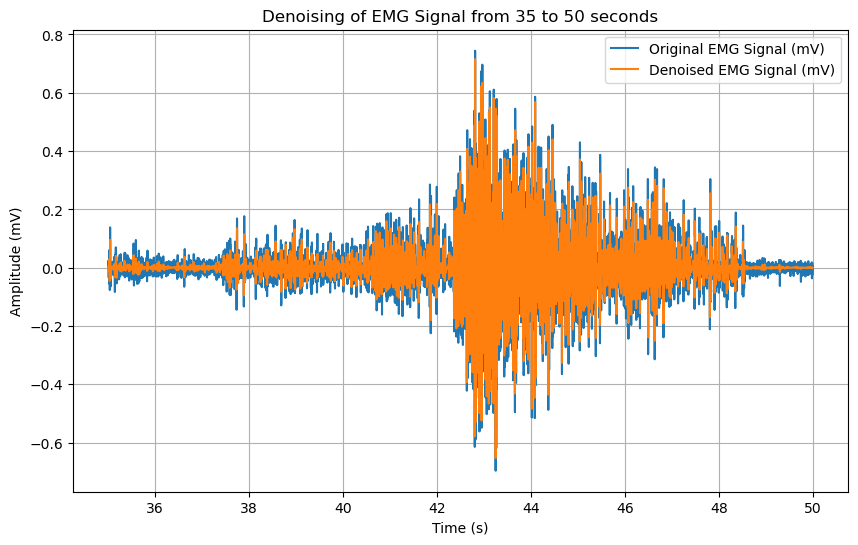

In [25]:
# Define the time range for the first 10 seconds
start_time = 35
end_time = 50

# Find the corresponding sample indices for the time range
start_index = int(start_time * fs)  # Convert start time to samples
end_index = int(end_time * fs)      # Convert end time to samples

# Slice the original and denoised signals for the first 10 seconds
senalmV_0_10 = senalV_centered[start_index:end_index]
emg_denoised_0_10 =emg_denoised_centered[start_index:end_index]
tiempo_seconds_0_10 = tiempo_seconds[start_index:end_index]

# Plot the original and denoised signals for the first 10 seconds
plt.figure(figsize=(10, 6))
plt.plot(tiempo_seconds_0_10, senalmV_0_10, label='Original EMG Signal (mV)')
plt.plot(tiempo_seconds_0_10, emg_denoised_0_10, label='Denoised EMG Signal (mV)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Denoising of EMG Signal from 35 to 50 seconds')
plt.legend()
plt.grid(True)
plt.show()